In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils_xmatch import wsi_gaia_xmatch
warnings.simplefilter(action='ignore', category=FutureWarning)

Load in wsi and filter catalog

In [2]:
# read in wsi and force data types
wsi = pd.read_csv('data/wsi24.sb.prop.csv').astype({ 
    'wsi_sep':float, 'wsi_sep_e':float, 
    'wsi_pa':float, 'wsi_pa_e':float, 
    'wsi_dm':float, 'wsi_dm_e':float,
    'wds_mag1':float, 'wds_mag2':float,
    'wds_pm1':float, 'wds_pm2':float,
})
print(len(wsi))

# final filters
sample = wsi.reset_index(drop=True)
# sample = wsi.loc[ wsi.wsi_sep > 0.8 ].reset_index(drop=True)
len(sample)

2868


2868

In [3]:
# export sample to query gaia
sample.to_csv('data/wsi.query_sample.csv', index=True, index_label='wsi_oid')

# Current setup
* 5 arcsec search radius
* queries gaia stars within 5 mags of match
* we propagate ALL secondaries

In [4]:
# load in data
wsi = pd.read_csv('data/wsi.query_sample.csv')
gaia_pri = pd.read_csv('data/pri-result.csv')
gaia_sec = pd.read_csv('data/sec-result.csv')

print( len(wsi) )
print( len(gaia_pri) )
print( len(gaia_sec) )

2868
4104
4033


In [5]:
# crossmatch with J2016 propagation
xmatch = wsi_gaia_xmatch( wsi, gaia_pri, gaia_sec )

# where did our crossmatch agree with simbad?
xmatch['xm_chk1'] = np.where( xmatch.gaia_id1 == xmatch.sb_id1, True, False )
xmatch['xm_chk2'] = np.where( xmatch.gaia_id2 == xmatch.sb_id2, True, False )

how many stars did we not find a match for?

In [6]:
print('no match candidates found in query')
print( 'primary:', list( xmatch.gaia_flag1 ).count('$') )
print( 'secondary:', list( xmatch.gaia_flag2 ).count('$') )

no match candidates found in query
primary: 29
secondary: 518


For the secondaries with no proper motion, how many matches are missing?

In [8]:
print( 'With PM:', list( xmatch.loc[xmatch.epoch_prop_flag != '!'].gaia_flag2 ).count('$') )
print( 'Without PM:', list( xmatch.loc[xmatch.epoch_prop_flag == '!'].gaia_flag2 ).count('$') )

With PM: 308
Without PM: 210


## SIMBAD Matches

We want to see a few data points:

1. Of the stars that simbad found a match for (no ! flag), what percentage do our cross matches agree?
2. Where does simbad have and not have matches? Specific separation? dm?
3. Of our matches that agree and disagree with simbad, do we see any trends in sep? dm?

In [9]:
# where simbad found pri match
sb1 = xmatch.loc[ xmatch.sb_flg1 == '.' ]
sbf1 = xmatch.loc[ xmatch.sb_flg1 == '!' ]
sbn1 = xmatch.loc[ xmatch.sb_flg1 == '$' ]

# where simbad found sec match
sb2 = xmatch.loc[ xmatch.sb_flg2 == '.' ]
sbf2 = xmatch.loc[ xmatch.sb_flg2 == '!' ]
sbn2 = xmatch.loc[ xmatch.sb_flg2 == '$' ]

print( 'direct |', 'pri:', len(sb1), 'sec:', len(sb2) )
print( 'flagged |', 'pri:', len(sbf1), 'sec:', len(sbf2) )
print( 'no match |', 'pri:', len(sbn1), 'sec:', len(sbn2) )

direct | pri: 2079 sec: 1636
flagged | pri: 19 sec: 10
no match | pri: 770 sec: 1222


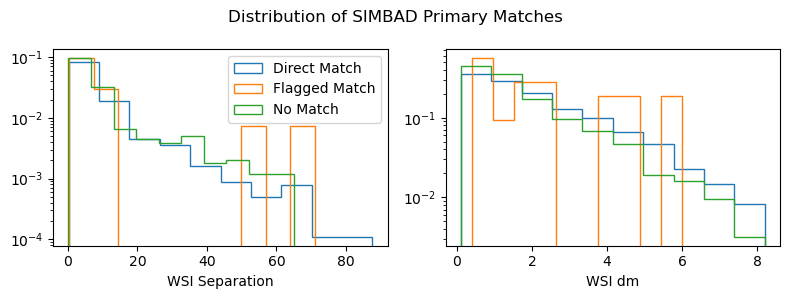

In [10]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(8,3) )
fig.suptitle('Distribution of SIMBAD Primary Matches')

ax1.hist( sb1.wsi_sep, histtype='step', density=True, label='Direct Match' )
ax1.hist( sbf1.wsi_sep, histtype='step', density=True, label='Flagged Match' )
ax1.hist( sbn1.wsi_sep, histtype='step', density=True, label='No Match' )
ax1.set_yscale('log')
ax1.set_xlabel('WSI Separation')
ax1.legend()

ax2.hist( sb1.wsi_dm, histtype='step', density=True, label='Direct Match' )
ax2.hist( sbf1.wsi_dm, histtype='step', density=True, label='Flagged Match' )
ax2.hist( sbn1.wsi_dm, histtype='step', density=True, label='No Match' )
ax2.set_yscale('log')
ax2.set_xlabel('WSI dm')

plt.tight_layout()
plt.savefig('plots/sb_pri.png', dpi=300)
plt.show()

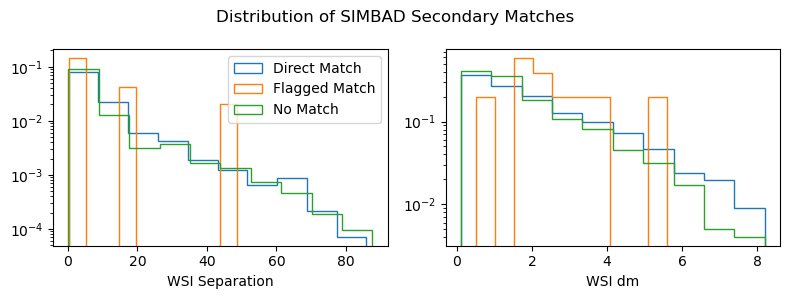

In [11]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(8,3) )
fig.suptitle('Distribution of SIMBAD Secondary Matches')

ax1.hist( sb2.wsi_sep, histtype='step', density=True, label='Direct Match' )
ax1.hist( sbf2.wsi_sep, histtype='step', density=True, label='Flagged Match' )
ax1.hist( sbn2.wsi_sep, histtype='step', density=True, label='No Match' )
ax1.set_yscale('log')
ax1.set_xlabel('WSI Separation')
ax1.legend()

ax2.hist( sb2.wsi_dm, histtype='step', density=True, label='Direct Match' )
ax2.hist( sbf2.wsi_dm, histtype='step', density=True, label='Flagged Match' )
ax2.hist( sbn2.wsi_dm, histtype='step', density=True, label='No Match' )
ax2.set_yscale('log')
ax2.set_xlabel('WSI dm')

plt.tight_layout()
plt.savefig('plots/sb_sec', dpi=300)
plt.show()

## My Crossmatch results

Comparing to SIMBAD and histograms

In [12]:
print( sb1.xm_chk1.value_counts(True) )
print()
print( sb2.xm_chk2.value_counts(True) )

xm_chk1
True     0.950457
False    0.049543
Name: proportion, dtype: float64

xm_chk2
True     0.900978
False    0.099022
Name: proportion, dtype: float64


In [13]:
sb1T = sb1.loc[ sb1.xm_chk1==True ]
sb1F = sb1.loc[ sb1.xm_chk1==False ]

sb2T = sb2.loc[ sb2.xm_chk2==True ]
sb2F = sb2.loc[ sb2.xm_chk2==False ]

In [14]:
print( 'Primaries, SIMBAD Direct:' )
print( 'match:', len(sb1T), '|', 'no match:', len(sb1F) )
print('============================')
print( 'Secondaries, SIMBAD Direct:' )
print( 'match:', len(sb2T), '|', 'no match:', len(sb2F) )

Primaries, SIMBAD Direct:
match: 1976 | no match: 103
Secondaries, SIMBAD Direct:
match: 1474 | no match: 162


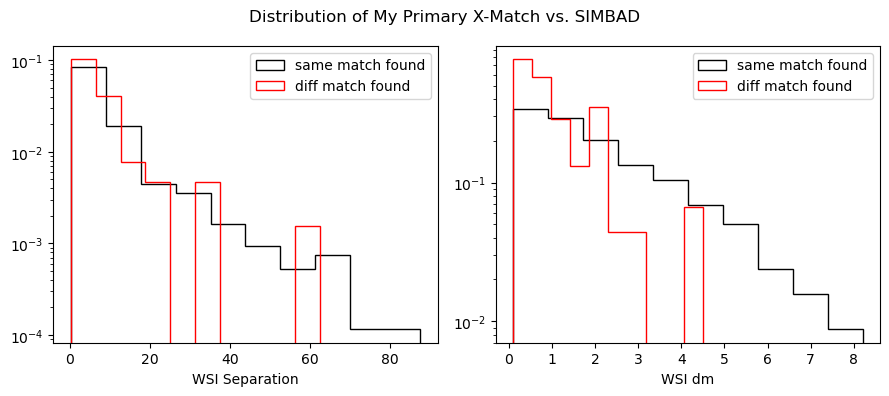

In [15]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(9,4) )
fig.suptitle('Distribution of My Primary X-Match vs. SIMBAD')
    
ax1.hist(sb1T.wsi_sep, histtype='step', color='k', density=True, label='same match found')
ax1.hist(sb1F.wsi_sep, histtype='step', color='r', density=True, label='diff match found')
ax1.set_yscale('log')
ax1.set_xlabel('WSI Separation')
ax1.legend()

ax2.hist(sb1T.wsi_dm, histtype='step', color='k', density=True, label='same match found')
ax2.hist(sb1F.wsi_dm, histtype='step', color='r', density=True, label='diff match found')
ax2.set_yscale('log')
ax2.set_xlabel('WSI dm')
ax2.legend()

plt.tight_layout()
plt.savefig('plots/me_sb_pri.png', dpi=300)
plt.show()

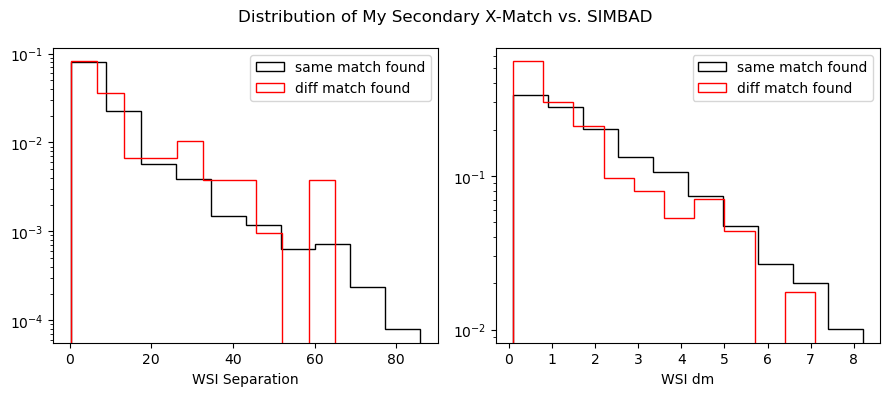

In [16]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(9,4) )
fig.suptitle('Distribution of My Secondary X-Match vs. SIMBAD')
    
ax1.hist(sb2T.wsi_sep, histtype='step', color='k', density=True, label='same match found')
ax1.hist(sb2F.wsi_sep, histtype='step', color='r', density=True, label='diff match found')
ax1.set_yscale('log')
ax1.set_xlabel('WSI Separation')
ax1.legend()

ax2.hist(sb2T.wsi_dm, histtype='step', color='k', density=True, label='same match found')
ax2.hist(sb2F.wsi_dm, histtype='step', color='r', density=True, label='diff match found')
ax2.set_yscale('log')
ax2.set_xlabel('WSI dm')
ax2.legend()

plt.tight_layout()
plt.savefig('plots/me_sb_sec.png', dpi=300)
plt.show()

What do the mag vs mag and pm plots look like for the stars that agree with simbad?

In [17]:
# xmatch with targets we got a result from
xm = xmatch.loc[ (xmatch.gaia_flag1 != '$') & (xmatch.gaia_flag2 != '$') ].reset_index(drop=True)

# everything propagated using its own pm
pm = xm.loc[ xm.epoch_prop_flag != '!' ].reset_index(drop=True)

# sec propagated using primary
npm = xm.loc[ xm.epoch_prop_flag == '!' ].reset_index(drop=True)

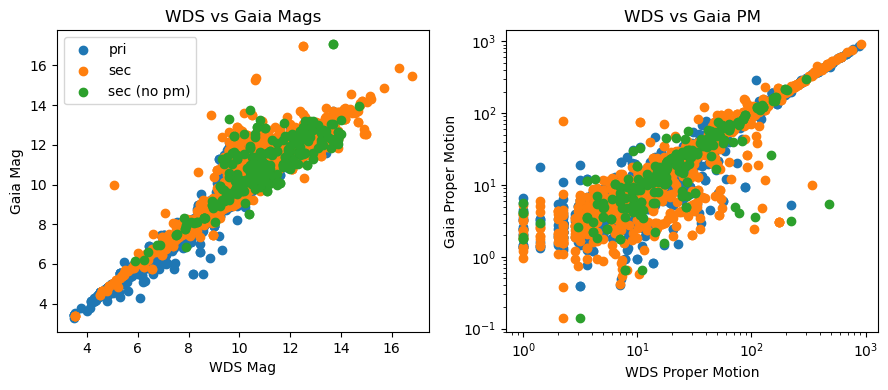

In [18]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(9,4) )

ax1.scatter(xm.wds_mag1, xm.gaia_mag1, label='pri')
ax1.scatter(pm.wds_mag2, pm.gaia_mag2, label='sec')
ax1.scatter(npm.wds_mag2, npm.gaia_mag2, label='sec (no pm)')
ax1.set_title('WDS vs Gaia Mags')
ax1.set_xlabel('WDS Mag')
ax1.set_ylabel('Gaia Mag')
ax1.legend()

ax2.scatter(xm.wds_pm1, xm.gaia_pm1, label='pri')
ax2.scatter(pm.wds_pm2, pm.gaia_pm2, label='sec')
ax2.scatter(npm.wds_pm1, npm.gaia_pm2, label='sec (no pm)')
ax2.set_title('WDS vs Gaia PM')
ax2.set_xlabel('WDS Proper Motion')
ax2.set_ylabel('Gaia Proper Motion')
# ax2.legend()
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('plots/wds_gaia.png', dpi=300)
plt.show()

In [19]:
# only plot targets we got a match for
sb1T = xm.loc[ (xm.sb_flg1 == '.') & (xm.xm_chk1 == True) ].reset_index(drop=True)
sb2T = pm.loc[ (pm.sb_flg2 == '.') & (pm.xm_chk2 == True) ].reset_index(drop=True)
sb2TNPM = npm.loc[ (npm.sb_flg2 == '.') & (npm.xm_chk2 == True) ].reset_index(drop=True)

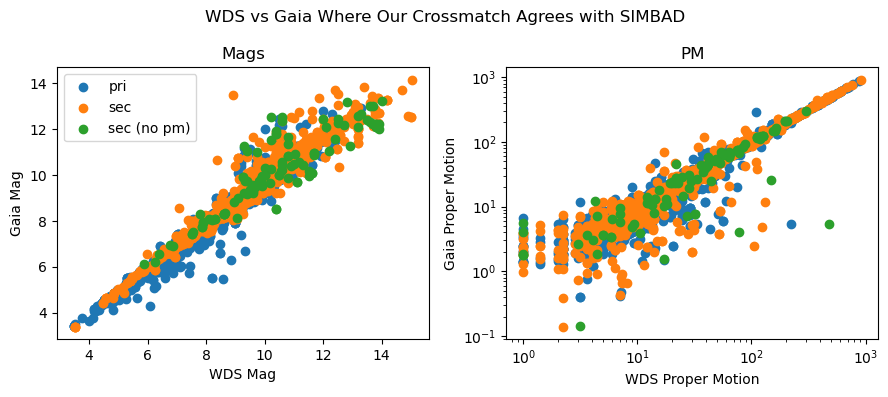

In [30]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(9,4) )
plt.suptitle( 'WDS vs Gaia Where Our Crossmatch Agrees with SIMBAD' )

ax1.scatter(sb1T.wds_mag1, sb1T.gaia_mag1, label='pri')
ax1.scatter(sb2T.wds_mag2, sb2T.gaia_mag2, label='sec')
ax1.scatter(sb2TNPM.wds_mag2, sb2TNPM.gaia_mag2, label='sec (no pm)')
ax1.set_title('Mags')
ax1.set_xlabel('WDS Mag')
ax1.set_ylabel('Gaia Mag')
ax1.legend()

ax2.scatter(sb1T.wds_pm1, sb1T.gaia_pm1)
ax2.scatter(sb2T.wds_pm2, sb2T.gaia_pm2)
ax2.scatter(sb2TNPM.wds_pm1, sb2TNPM.gaia_pm2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('PM')
ax2.set_xlabel('WDS Proper Motion')
ax2.set_ylabel('Gaia Proper Motion')

plt.tight_layout()
plt.savefig('plots/wds_gaia_sb_match.png', dpi=300)
plt.show()

## Juliens Crossmatch

In [31]:
from utils_misc import *

In [32]:
jxm = pd.read_csv('data/xmatch_old/crossmatch_gaiadr3_wds_nov_15_2023.txt')
jxm = jxm.rename( columns={'wds_wds':'wds_id'} )
jxm.iloc[:5]

,wds_recno,wds_id,wds_ra,wds_de,wds_mag1,wds_mag2,wds_sep1,wds_sep2,gaia_source_id,gaia_ra_2016,gaia_de_2016,gaia_pmra,gaia_pmde,gaia_gmag,gaia_non_single_star,gaia_ra_2000,gaia_de_2000,dist_arcsec_2000
0,5,00000+0044,359.999375,0.725750,17.80,17.8,0.8,1.0,2738296192437006848,359.999223,0.725537,-17.023790,-24.723146,17.215240,0,359.999298,0.725647,0.462942
1,6,00000-0530,0.000333,-5.494361,9.50,9.7,0.1,0.1,2443095153084654208,0.000435,-5.494409,22.498114,-11.301015,8.871953,0,0.000334,-5.494359,0.008051
2,4,00000+3852,0.005000,38.859278,6.62,11.4,6.7,6.6,2881742980523997824,0.005059,38.859269,5.761322,-2.405559,6.596025,0,0.005026,38.859280,0.073485
3,2,00000+4004,0.015250,40.088722,12.10,13.1,4.8,4.4,2881879556188096896,0.015232,40.088699,-0.488102,-3.807620,12.115115,0,0.015235,40.088716,0.047365
4,3,00000+4004,0.015250,40.088722,12.10,14.1,20.0,14.4,2881879556188096896,0.015232,40.088699,-0.488102,-3.807620,12.115115,0,0.015235,40.088716,0.047365


In [33]:
jxm_id1 = []

# for an entry in jxm, find the match in xm based off of wds id and wds mag1
for i, wds_id in enumerate( xmatch.wds_id ):
    
    # identify primary by mag1
    mag = xmatch.wds_mag1.iloc[i]

    # find match in wsi xmatch
    match = jxm.loc[ (jxm['wds_id']==wds_id) & (jxm['wds_mag1']==mag) ]

    # add Julien's xmatch to list
    try:
        jxm_id1.append( 'Gaia DR3 ' + str( match.gaia_source_id.iloc[0] ) )
    except:
        jxm_id1.append('$')

# add to our xmatch
xmatch['jxm_id1'] = jxm_id1

In [34]:
xmatch['jxm_chk'] = np.where( xmatch.gaia_id1==xmatch.jxm_id1, True, False )
xmatch['sb_jxm_chk'] = np.where( xmatch.jxm_id1==xmatch.sb_id1, True, False )

Julien's x-match vs SIMBAD

In [38]:
sb1 = xmatch.loc[ xmatch.sb_flg1 == '.' ]
sbf1 = xmatch.loc[ xmatch.sb_flg1 == '!' ]
sbn1 = xmatch.loc[ xmatch.sb_flg1 == '$' ]

both = xmatch.loc[ (xmatch.gaia_flag1!='$') & (xmatch.jxm_id1!='$') ]

print( len(sb1), len(sbf1), len(sbn1), len(both) )

2079 19 770 2826


In [39]:
print( len( sb1.loc[ (sb1.xm_chk1==False) ] ) )
print( len( sb1.loc[ (sb1.sb_jxm_chk==False) ] ) )

103
136


In [40]:
all = sb1.loc[ (sb1.xm_chk1==True) & (sb1.sb_jxm_chk==True) ] # all gaia ids match
nxm = sb1.loc[ (sb1.xm_chk1==False) & (sb1.gaia_flag1!='$') & (sb1.jxm_id1!='$') ] # where mine were wrong but NOT empty
njm = sb1.loc[ (sb1.sb_jxm_chk==False) & (sb1.gaia_flag1!='$') & (sb1.jxm_id1!='$') ] # where juliens were wrong but NOT empty

print( len(all), len(nxm), len(njm) )

1920 76 120


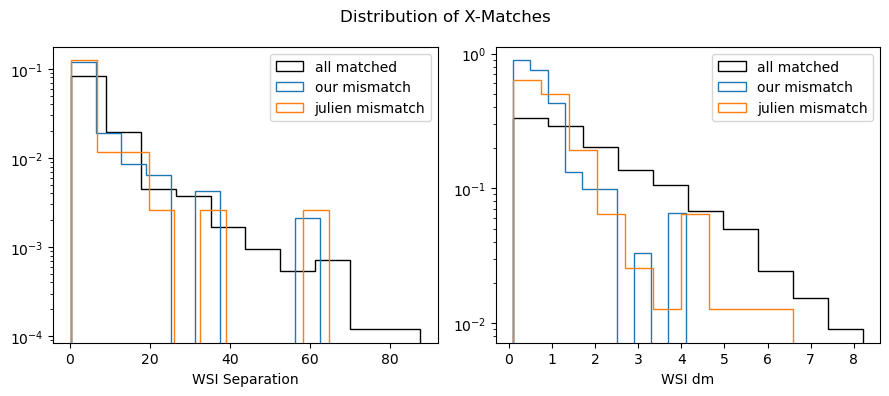

In [41]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(9,4) )
fig.suptitle('Distribution of X-Matches')
    
ax1.hist(all.wsi_sep, histtype='step', color='k', density=True, label='all matched')
ax1.hist(nxm.wsi_sep, histtype='step', density=True, label='our mismatch')
ax1.hist(njm.wsi_sep, histtype='step', density=True, label='julien mismatch')
ax1.set_yscale('log')
ax1.set_xlabel('WSI Separation')
ax1.legend()

ax2.hist(all.wsi_dm, histtype='step', color='k', density=True, label='all matched')
ax2.hist(nxm.wsi_dm, histtype='step', density=True, label='our mismatch')
ax2.hist(njm.wsi_dm, histtype='step', density=True, label='julien mismatch')
ax2.set_yscale('log')
ax2.set_xlabel('WSI dm')
ax2.legend()

plt.tight_layout()
plt.savefig('plots/all_xmatch_compared.png', dpi=300)
plt.show()

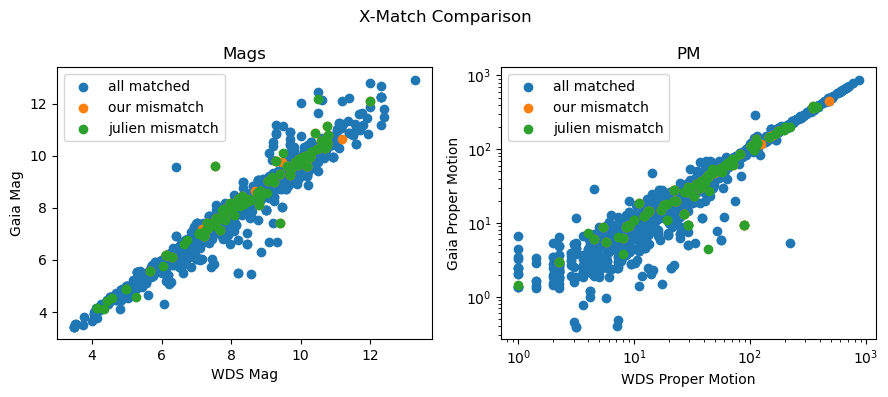

In [42]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(9,4) )
plt.suptitle( 'X-Match Comparison' )

ax1.scatter(all.wds_mag1, all.gaia_mag1, label='all matched')
ax1.scatter(nxm.wds_mag1, nxm.gaia_mag1, label='our mismatch')
ax1.scatter(njm.wds_mag1, njm.gaia_mag1, label='julien mismatch')
ax1.set_title('Mags')
ax1.set_xlabel('WDS Mag')
ax1.set_ylabel('Gaia Mag')
ax1.legend()

ax2.scatter(all.wds_pm1, all.gaia_pm1, label='all matched')
ax2.scatter(nxm.wds_pm1, nxm.gaia_pm1, label='our mismatch')
ax2.scatter(njm.wds_pm1, njm.gaia_pm1, label='julien mismatch')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('PM')
ax2.set_xlabel('WDS Proper Motion')
ax2.set_ylabel('Gaia Proper Motion')
ax2.legend()

plt.tight_layout()
plt.savefig('plots/all_xmatch.png', dpi=300)
plt.show()

In [59]:
# xmatch.to_csv('data/wsi24.xmatch.csv', index=False)